# MLP(Multi Layer Perceptron) 설계하기
CIFAR-10 데이터로 다중 레이어 신경망 설계

In [1]:
# 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# 딥러닝시 장비 확인(cpu 사용)
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
    
BATCH_SIZE = 32
EPOCHS = 10

In [2]:
train_dataset = datasets.CIFAR10(root='./data/CIFAR_10', train=True, download=True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data/CIFAR_10', train=False, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [3]:
# 데이터 확인
for(X_train, y_train) in train_loader:
    print('X_train : ', X_train.size(), 'type : ', X_train.type())
    print('y_train : ', y_train.size(), 'type : ', y_train.type())
    break
    # 가로 32, 세로 32의 컬러(Red, Green, Blue) 이미지 32이개 하나의 미니 배치를 구성

X_train :  torch.Size([32, 3, 32, 32]) type :  torch.FloatTensor
y_train :  torch.Size([32]) type :  torch.LongTensor


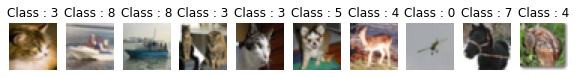

In [10]:
# 이미지 출력
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class : ' + str(y_train[i].item()))

In [5]:
# MLP 모델 생성
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  #이미지(가로 * 세로 * 채널) 입력
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)     # log_softmax를 사용하는 이유는 Back Propagation으로 학습이 원활하게 진행되도록 하기 위함
        return x

In [45]:
# Optimizer, Objective Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 옵티마이저는 SGD 알고리즘
criterion = nn.CrossEntropyLoss()                           # 손실함수는 CrossEntropy사용
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [7]:
# 모델 학습 및 성능 확인
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                    # 모델을 학습상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):        # 미니배치 단위로 학습
        image = image.to(DEVICE)                                     # 
        label = label.to(DEVICE)
        optimizer.zero_grad()                                        # 옵티마이저 그래디언트 값으 0으로 설정
        output = model(image)                            
        loss = criterion(output, label)                              # Loss 값 계산
        loss.backward()                                              # 그래디언트 값을 각 파라미터에 전달
        optimizer.step()                                             # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print('Train Epoch : {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [18]:
# 학습되며 검증 데이터에 대한 모델 성능 확인
def evaluate(model, test_loader):
    model.eval()                                                                 # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad():                                                        # 그래디언트 흐름 억제
        for image, label in test_loader:
            image = image.to(DEVICE)    
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()                         # loss 값 계산후 더한다
            prediction = output.max(1, keepdim = True)[1]                        # OUtput 중에서 가장 큰 값에 대응하는 클래스로 예측했다고 판단
            correct += prediction.eq(label.view_as(prediction)).sum().item()     # 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스를 비교해 맞으면 올바르게 예측한 횟수를 저장한다
    test_loss /= len(test_loader.dataset)                                        # 평균 Loss 값을 구한다
    test_accuracy = 100. * correct / len(test_loader.dataset)                    # 정확도 계산
    return test_loss, test_accuracy                                             

In [19]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy: {:.2f} %\n'.format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/50000(0%)]	Train Loss: 1.258542
Train Epoch : 1 [6400/50000(13%)]	Train Loss: 1.334048
Train Epoch : 1 [12800/50000(26%)]	Train Loss: 1.233780
Train Epoch : 1 [19200/50000(38%)]	Train Loss: 1.304990
Train Epoch : 1 [25600/50000(51%)]	Train Loss: 1.239631
Train Epoch : 1 [32000/50000(64%)]	Train Loss: 1.408470
Train Epoch : 1 [38400/50000(77%)]	Train Loss: 1.167177
Train Epoch : 1 [44800/50000(90%)]	Train Loss: 1.210575

[EPOCH : 1], 	Test Loss : 0.0465, 	Test Accuracy: 47.24 %

Train Epoch : 2 [0/50000(0%)]	Train Loss: 1.319342
Train Epoch : 2 [6400/50000(13%)]	Train Loss: 1.512622
Train Epoch : 2 [12800/50000(26%)]	Train Loss: 1.509919
Train Epoch : 2 [19200/50000(38%)]	Train Loss: 1.660992
Train Epoch : 2 [25600/50000(51%)]	Train Loss: 1.527964
Train Epoch : 2 [32000/50000(64%)]	Train Loss: 2.099076
Train Epoch : 2 [38400/50000(77%)]	Train Loss: 1.356821
Train Epoch : 2 [44800/50000(90%)]	Train Loss: 1.229176

[EPOCH : 2], 	Test Loss : 0.0465, 	Test Accuracy: 47.36

# CIFAR-10 데이터로 CNN 설계하기
컬러 이미지의 경우 1차원으로 펼칠 시 이미지의 특징을 더 잘 잃어버린다.

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = 3,
            padding=1
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride = 2
        )
        self.fc1 = nn.Linear(8 * 8 * 16 , 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

### CIFAR-10 데이터에 Augmentation 기법으로 모델 성능 향상
Data Augmentation은 기존 데이터에 자르기, 회전하기, 돌리기 등 변형을 주는것

In [27]:
train_dataset = datasets.CIFAR10(root='./data/CIFAR_10', 
                                train=True, 
                                download=True,
                                transform = transforms.Compose([                             # Conpose는 이미지 데이터에 전처리 및 Augmentation을 다양하게 적용하는 메서드
                                    transforms.RandomHorizontalFlip(),                       # 데이터를 50% 확률로 좌우 반전
                                    transforms.ToTensor(),                                   # 0~1 값으로 정규화
                                    transforms.Normalize((0.5, 0.5, 0.5),                    # 또다른 정규화를 한다. 정규화시 필요한 평균 & 표준편차를 red, green, blue 순으로 0.5씩 적용
                                    (0.5, 0.5, 0.5))                                         # transforms.Normalize 진행시 필요한 표준편차
                                ]))
test_dataset = datasets.CIFAR10(root='./data/CIFAR_10',
                                train=False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))
                                ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


### CIFAR-10 데이터에 고급 CNN 모델을 적용해 성능 향상
CNN 모델은 LeNet, AlexNet, VGG, GoogLeNetm ResNet 등이 있다.

In [38]:
# ResNet 모델 설계
class BasicBlock(nn.Module):                                 # 모델 설계시 반복적으로 이용하는 블록을 정의
    def __init__(self, in_planes, planes, stride=1):         # 인스턴스
        super(BasicBlock, self).__init__()               
        self.conv1 = nn.Conv2d(in_planes, planes,            # Convolution 연산하는 필터 정의 데이터 채널 수(in_planes) 정의, 필터 개수 정의(planes)
                              kernal_size=3,                 # 필터 크기
                              stride = stride,               # 필터가 움직이는 단위
                              padding = 1,                   # 
                              bias = False)                  # 컨볼루션 연산 시 각 값들을 컨볼루션 연산 후 Bias 값을 더해줄 것인지 지정
        self.bn1 = nn.BatchNorm2d(planes)                    # 각 레이어마다 input 분포가 달라져 학습 속도 느려짐을 방지한다.
        self.conv2 = nn.Conv2d(planes, planes,               # Convolution 연산을 하는 필터를 정의
                              kernel_size = 3,               # 필터 크기 지정 3 * 3으로
                              stride = 1,                    # 필터의 이동 단위 1칸씩 지정
                              padding = 1,                   # 케케 이건 패딩이라구
                              bias = False)                  # 컨볼루션 연산 시 각 값들을 컨볼루션 연산 후 Bias 값을 더해줄 것인지 지정
        self.bn2 = nn.BatchNorm2d(planes)                    # planes 크기의 데이터에 대해 적용 할 수 있는 BatchNorm2d를 정의
        
        self.shortcut = nn.Sequential()                      # Shortcut 정의(Shortcut은 기존 값과 컨볼루션 및 배치 Normalization한 결과를 더하는 과정)
        if stride != 1 or in_planes != planes:               # 두번째 블록부터 정용되는 shortcut 정의
            self.shortcut = nn.Sequential(                   # shortcut 정의
                nn.Conv2d(in_planes, planes,                 # 컨볼루션 연산을 하는 필터 정의
                         kernel_size = 1,
                         stride = stride,
                         bias = False),
                nn.BatchNorm2d(planes))                      # Planes 크기의 데이터에 적용할 수 있는 BatchNorm2d를 정의
    def forward(self, x):                                 
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, num_classes=10):                      # 예측 클래스는 10개
        super(ResNet, self).__init__()
        self.in_planes = 16                                  # 컨볼루션 계산 시 16의 채널수를 바탕으로
        self.conv1 = nn.Conv2d(3, 16,                        # BasicBlock 클래스 내의 conv1과는 다름
                              kernel_size = 3,               # 필터는 3 * 3
                              stride = 1,                    # 이동 단위는 1칸
                              padding = 1,                   # 케케 패딩도 한줌 뿌려 주고
                              bias = False)                  # 먼지 몰라도 돼 차피 안씀 ㅋ
        self.bn1 = nn.BatchNorm2d(16)                        # 벡터 크기가 16인 2차원 데이터에 적용 가능한 Batch Normalization 연산 정의
        self.layer1 = self._make_layer(16, 2, stride = 1)    
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)             
        
    def _make_layer(self, planes, num_blocks, stride):       
        strides = [stride] + [1] * (num_blocks -1)           # BasicBlock으로 생성된 결괏값 추가를 위해 빈 리스트 정의
        layers = [] 
        for stride in strides:                               # strides의 범위인 stride 값으로 생성한 BasicBlock의 결괏값을 리스트에 넣는다.
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes                          # Shourtcut 계산을 위해 Planes 값으로 업데이트
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out                        # 최종적으로 CNN에서 정확도가 약 66%지만 ResNet에서는 82%까지 달성했다.

### 파이토치 제공 모델로 CIFAR-10 Dataset 분류하기
파이토치에는 AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception, GoogLeNet 등을 제공한다

In [40]:
import torchvision.models as models
model = models.resnet34(pretrained = False)   # 모델 resnet34 모델을 불러옴(pretrained가 True면 파라미터까지 가져옴)
num_ftrs = model.fc.in_features               # 모델의 Fully Connected Layer의 Input에 해당하는 노드수를 저장
model.fc = nn.Linear(num_ftrs, 10)            # 
model = model.to(DEVICE)

In [47]:
# ImageNet 데이터로 학습된 resNet34 모델을 불러온 후 Fine-tuning하기
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/50000(0%)]	Train Loss: 2.821456
Train Epoch : 1 [6400/50000(13%)]	Train Loss: 1.285084
Train Epoch : 1 [12800/50000(26%)]	Train Loss: 0.889168
Train Epoch : 1 [19200/50000(38%)]	Train Loss: 0.913910
Train Epoch : 1 [25600/50000(51%)]	Train Loss: 0.775036
Train Epoch : 1 [32000/50000(64%)]	Train Loss: 1.224273
Train Epoch : 1 [38400/50000(77%)]	Train Loss: 1.231747


KeyboardInterrupt: 